In [37]:
from utils.load import make_total_df,get_feature_names, get_indv_df
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.pyplot as plt
df = make_total_df()
#df = df.drop("Y_labels", axis=1)

In [38]:
distance = pd.read_csv("data/distance_data/processed_distances.csv")
df_filled = distance.fillna(0)
df_arr = df_filled.to_numpy().reshape(-1, 1)


In [39]:
distance = pd.read_csv("data/distance_data/processed_distances.csv")
feature_names = get_feature_names('cos') + get_feature_names('euc') + get_feature_names('man') + get_feature_names('het')
x = df.loc[:, feature_names].values 
x = np.concatenate((x, df_arr), axis=1)

x = StandardScaler().fit_transform(x) # normalizing the features
mean_vec = np.mean( x, axis=0)
cov_mat = np.cov( x.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

res = [n for n,i in enumerate(cum_var_exp) if i>90 ][0]  # Amount of vectors needed to explain 90 percent of the variance
pca = PCA(n_components=7)
pca.fit(x)
X = pca.transform(x)




In [40]:
Y = df["Y_labels"]
Y = np.log10(Y)

cos


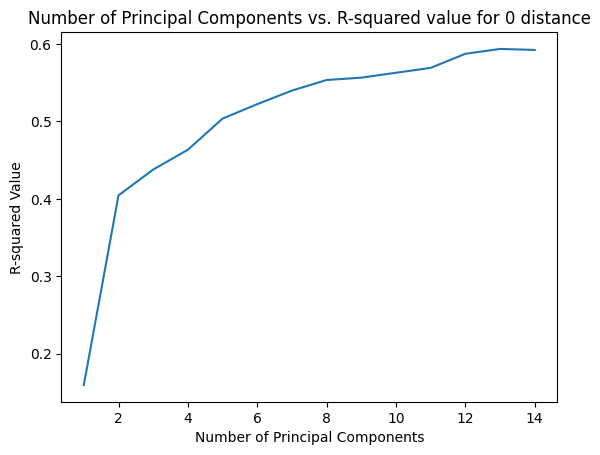

euc


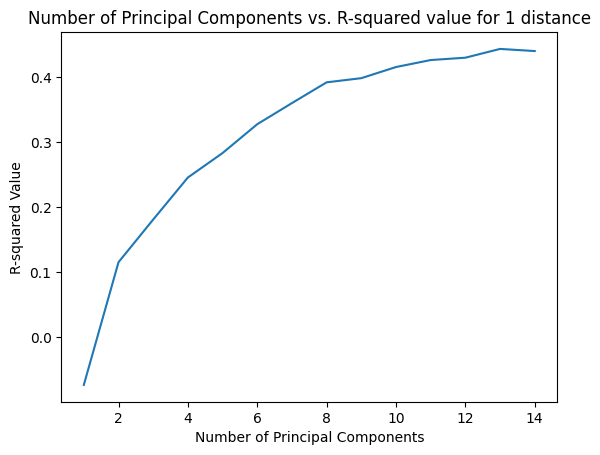

man


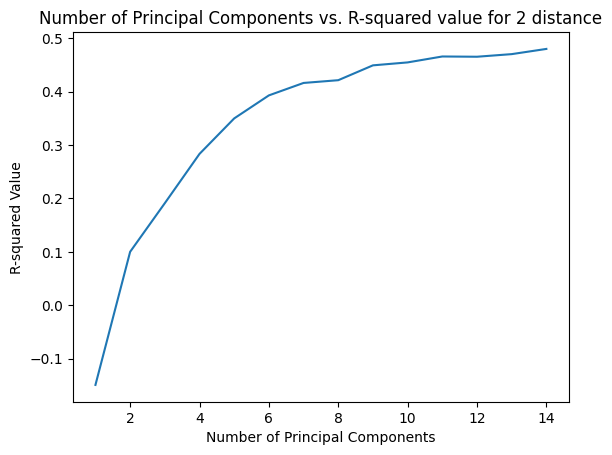

het


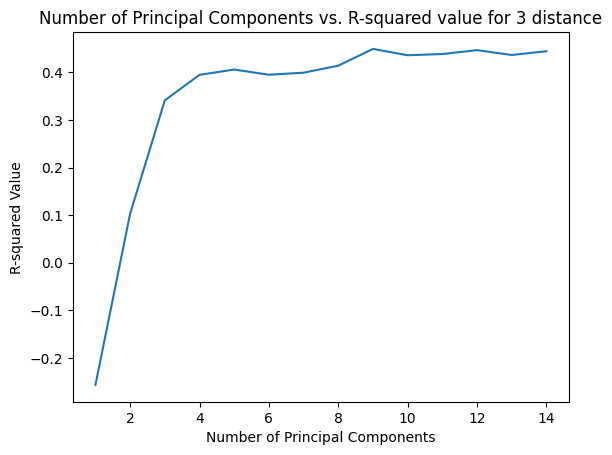

In [46]:
pcas = []
r2_scores = []

metrics = ['cos','euc','man','het']

for met in range(4):
    print(metrics[met])
    pcas = []
    r2_scores = []

    for i in range(1,15):
        feature_names = get_feature_names(metrics[met])# + get_feature_names('euc') + get_feature_names('man') + get_feature_names('het')
        x = df.loc[:, feature_names].values 
        pca = PCA(n_components=i)
        pca.fit(x)
        X = pca.transform(x)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
        rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)
        prediction = rf.predict(X_test)
        r2 = r2_score(y_test, prediction)
        pcas.append(i)
        r2_scores.append(r2)

    plt.plot(pcas, r2_scores)

    # Add axis labels and a title to the plot
    plt.xlabel('Number of Principal Components')
    plt.ylabel('R-squared Value')
    plt.title("Number of Principal Components vs. R-squared value for {} distance".format(metric[met]))


  #  plt.axvline(10, color='r', linestyle='--')

    # Show the plot
    plt.show()


## All data

In [54]:
pcas = []
r2_scores = []
for i in range(1,45):
    feature_names = get_feature_names(metrics('cos')) + get_feature_names('euc') + get_feature_names('man') + get_feature_names('het')
    x = df.loc[:, feature_names].values 
   # x = np.concatenate((x, df_arr), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=0.20, random_state=42)

    pca = PCA(n_components=i)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)
    prediction = rf.predict(X_test)
    r2 = r2_score(y_test, prediction)
    pcas.append(i)
    r2_scores.append(r2)

TypeError: 'list' object is not callable

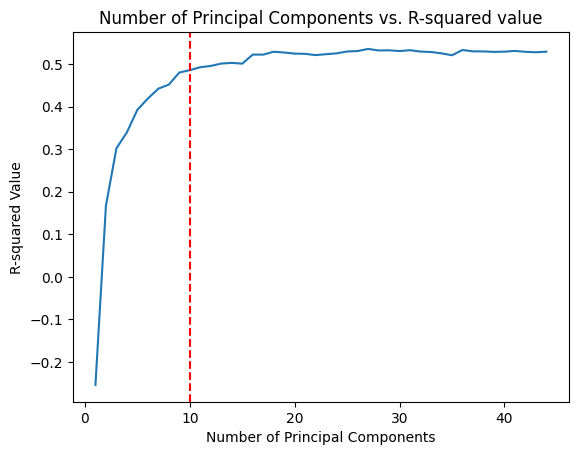

In [23]:
plt.plot(pcas, r2_scores)

# Add axis labels and a title to the plot
plt.xlabel('Number of Principal Components')
plt.ylabel('R-squared Value')
plt.title('Number of Principal Components vs. R-squared value')

plt.axvline(10, color='r', linestyle='--')

# Show the plot
plt.show()

In [24]:
print(pcas)
print(r2_scores)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
[-0.254054464091114, 0.16709825587146288, 0.3016940831449241, 0.33959803948499234, 0.39243303460489387, 0.41892671749776167, 0.44207305250650175, 0.45163149277423875, 0.47991437766970746, 0.48552698351878243, 0.49246943196103676, 0.49544042675797817, 0.5010192059941359, 0.5026363044422385, 0.5007800662338958, 0.522069710724306, 0.5219951104401541, 0.5288575058962544, 0.5269641609886817, 0.5244077651831474, 0.5238355252021082, 0.5209320620927267, 0.523023583218243, 0.5249660082664949, 0.5293974407771149, 0.5304386279630642, 0.5354212295321357, 0.5318098555579506, 0.532166067074263, 0.5304468919115524, 0.5323848737675803, 0.5291715891929127, 0.528145913194458, 0.5250526331695022, 0.5205391382234462, 0.5328307912693514, 0.529759650675032, 0.5295351433413853, 0.5284564856378455, 0.5290017693581504, 0.5307135424636606, 0.5286

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

In [18]:
prediction = rf.predict(X_test)
r2 = r2_score(y_test, prediction)
print(r2)


0.5413308414526772


Random forest on the whole dataset

In [28]:
from utils.load import load_everthing_old, make_total_df, load_everthing
import pandas as pd
import numpy as np

In [34]:
def rf_with_distance():

    X_dict, Y_dict = load_everthing_old()
    distance  = pd.read_csv("data/distance_data/processed_distances.csv")
    distance["0"] = distance["0"].fillna(0)
    distance = distance['0'].to_list()

    for key, value, new_number in zip(X_dict.keys(), X_dict.values(), distance):
        X_dict[key] = value + (new_number,)


    X = list(X_dict.values())
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = [i[0] for i in Y_dict.values()]
    Y = np.log10(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

    rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

    prediction = rf.predict(X_test)
    r2 = r2_score(y_test, prediction)
    print(r2)
    return y_test, prediction



def rf_without_distance():

    X_dict, Y_dict = load_everthing_old()
    X = list(X_dict.values())
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = [i[0] for i in Y_dict.values()]
    Y = np.log10(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

    rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

    prediction = rf.predict(X_test)
    r2 = r2_score(y_test, prediction)
    print(r2)

    return y_test, prediction




0.7056631841258458


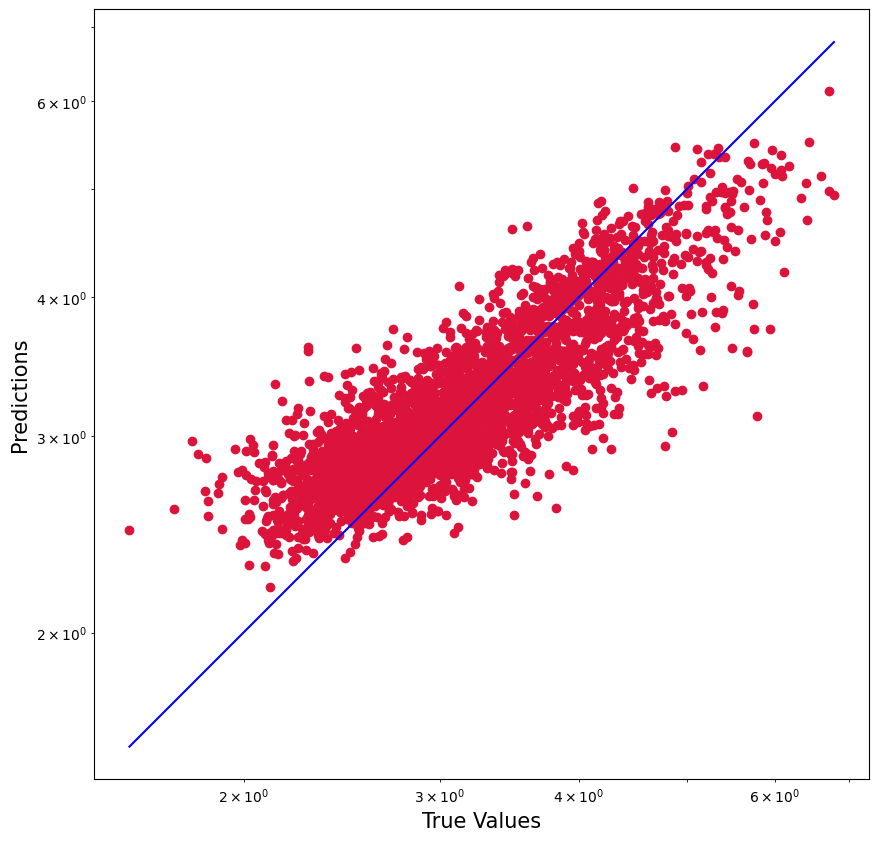

In [36]:
y_test, prediction = rf_with_distance()

plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

0.6560880536154077


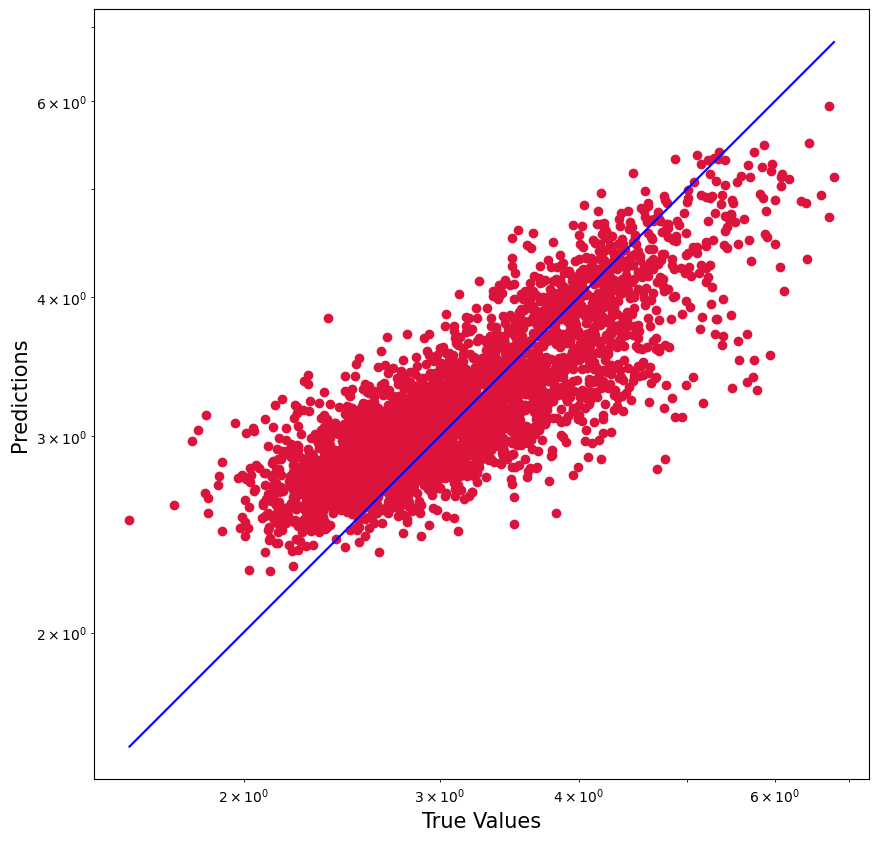

In [35]:

X_dict, Y_dict = load_everthing_old()
X = list(X_dict.values())
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = [i[0] for i in Y_dict.values()]
Y = np.log10(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

prediction = rf.predict(X_test)
r2 = r2_score(y_test, prediction)
print(r2)

plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [32]:
rf_with_distance()
rf_without_distance()

0.6560880536154077


### only distance

In [48]:
distance = pd.read_csv("data/distance_data/processed_distances.csv")
df_filled = distance.fillna(0)
df_arr = df_filled.to_numpy().reshape(-1, 1)
scaler = StandardScaler()
X = scaler.fit_transform(df_arr)
Y = [i[0] for i in Y_dict.values()]
Y = np.log10(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

prediction = rf.predict(X_test)
r2 = r2_score(y_test, prediction)
print(r2)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = None, min_samples_leaf=2, min_samples_split=2, random_state = 18).fit(X_train, y_train)

In [51]:
prediction = rf.predict(X_test)
r2 = r2_score(y_test, prediction)
print(r2)


0.18441134432843231


In [57]:
rf_with_distance = rf_with_distance()
rf_without_distance = rf_without_distance()
rf_only_distance = rf_only_distance()

0.7056631841258458
0.6560880536154077
0.18441134432843231


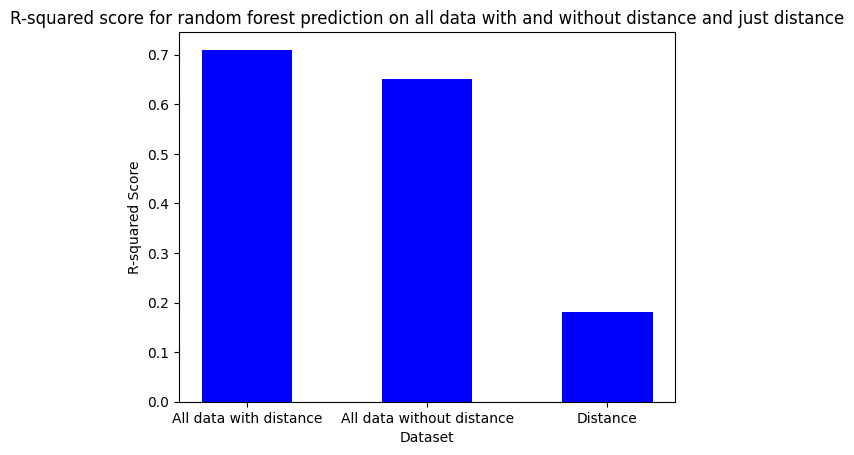

In [63]:

labels = ['All data with distance', 'All data without distance', 'Distance']
values = [0.71, 0.65, 0.18]
barWidth = 0.5
r1 = np.arange(len(values))
plt.bar(r1, values, width=barWidth, color='blue')

plt.xticks([r for r in range(len(values))], labels)

# Set plot title and axis labels
plt.title('R-squared score for random forest prediction on all data with and without distance and just distance')
plt.xlabel('Dataset')
plt.ylabel('R-squared Score')

# Show the plot
plt.show()